# Entrance Challenge: When Will the Sakura Bloom?

***

**Name：Hoang Loc NGUYEN**

**Email: hoangloc0402@gmail.com**

**Submission Date：Mar 11th 2019**

***

In [0]:
import urllib
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from sklearn.metrics import r2_score as sklearn_r2_score
from copy import deepcopy as clone
from datetime import date

In [0]:
def get_num_day_between(start_day, end_day):
    delta = end_day -start_day
    return delta.days

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2017 using the Japanese Meteorological Agency website (気象庁).

In [4]:
# Prepare urls for getting sakura blooming date data from JMA
url_prefix = "https://www.data.jma.go.jp/sakura/data/sakura003_0"
url_postfix = ".html"
urls = [url_prefix + str(x) + url_postfix for x in range(1,7)]
pprint(urls)

['https://www.data.jma.go.jp/sakura/data/sakura003_01.html',
 'https://www.data.jma.go.jp/sakura/data/sakura003_02.html',
 'https://www.data.jma.go.jp/sakura/data/sakura003_03.html',
 'https://www.data.jma.go.jp/sakura/data/sakura003_04.html',
 'https://www.data.jma.go.jp/sakura/data/sakura003_05.html',
 'https://www.data.jma.go.jp/sakura/data/sakura003_06.html']


In [0]:
# Function for getting data from one url of JMA website
re.DOTALL = False
def parse_url(url_input):
    fp = urllib.request.urlopen(url_input)
    raw_html_str = fp.read().decode("utf8")
    fp.close()
    tokyo_line = re.findall("東京 .*\n",  raw_html_str)[0]
    tokyo_num = re.findall("\d.*\d", tokyo_line)[0]
    tokyo_num = tokyo_num.split()[:-2]
    tokyo_num = [int(num) for num in tokyo_num]
    month = tokyo_num[0::2]
    date = tokyo_num[1::2]
    return month, date

In [0]:
# Getting sakura blooming date from the year of 1961 to 2017
bloom_year = range(1961,2018)
bloom_month = list()
bloom_date = list()
for url in urls:
    mon, dat = parse_url(url)
    bloom_month+=mon
    bloom_date+=dat
# Remove 2018
bloom_month = bloom_month[:-1]
bloom_date = bloom_date[:-1]
tokyo_bloom_date_data = list(zip(bloom_year, bloom_month, bloom_date))

In [7]:
#Create Dataframe from sakura blooming date data
print('Blooming data acquired from JMA website: ')
pd.DataFrame.from_dict({'year':bloom_year, 'month': bloom_month, 'date': bloom_date}).iloc[0:5,]

Blooming data acquired from JMA website: 


,date,month,year
0,1,4,1961
1,1,4,1962
2,1,4,1963
3,2,4,1964
4,2,4,1965


In [11]:
# Read data of Tokyo's weather condition from file
data_path = '/content/drive/My Drive/Colab Notebooks/sakura-blossom/tokyo.csv'
df_tokyo_weather = pd.read_csv(data_path, sep=',')
# I use Google Translate to rename all column labels to English
tokyo_weather_columns = ["index", "year", "month", "date","Local average pressure", 
                         "Sea level average pressure", "Total precipitation", 
                         "1 hour maximum precipitation", "10 minutes Maximum precipitation", 
                         "Average temperature", "Highest temperature", "Lowest Temperature", 
                         "Average humidity", "Minimum humidity", "Sunshine hours"]
df_tokyo_weather.set_axis(tokyo_weather_columns, axis = "columns", inplace=True)
df_tokyo_weather.iloc[0:5,]

,index,year,month,date,Local average pressure,Sea level average pressure,Total precipitation,1 hour maximum precipitation,10 minutes Maximum precipitation,Average temperature,Highest temperature,Lowest Temperature,Average humidity,Minimum humidity,Sunshine hours
0,0,1961,1,1,1011.7,1012.4,0.0,0.0,0.0,2.1,7.9,-3.9,41,15,8.6
1,1,1961,1,2,1020.2,1021.0,0.0,0.0,0.0,1.5,9.2,-3.3,51,26,8.7
2,2,1961,1,3,1021.3,1022.1,0.1,0.8,0.0,2.5,7.3,-2.4,58,37,5.4
3,3,1961,1,4,1004.6,1005.3,20.2,13.9,3.2,4.7,11.5,0.6,60,38,1.0
4,4,1961,1,5,1016.3,1017.0,0.0,0.0,0.0,3.8,7.7,1.4,33,19,8.3


In [0]:
df_tokyo = clone(df_tokyo_weather)
df_tokyo['is blooming date'] = False

for idx, row in df_tokyo.iterrows():
    year, month, date = row['year'], row['month'], row['date']
    if (year, month, date) in tokyo_bloom_date_data:
        df_tokyo.loc[idx,'is blooming date'] = True

In [0]:
# Split the test and train data
test_year = [1966, 1971, 1985, 1994, 2008] 
train_year = list(range(1961,2018))
for year in test_year:
    train_year.remove(year)
    
train_data = df_tokyo[~df_tokyo['year'].isin(test_year)]
test_data = df_tokyo[df_tokyo['year'].isin(test_year)]

In [14]:
print(train_year)

[1961, 1962, 1963, 1964, 1965, 1967, 1968, 1969, 1970, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

In [0]:
class predictor_600_degree_rule():
    def __init__(self, df_tokyo):
        self.T_mean = 0
        self.df_tokyo = df_tokyo
        self.accumulated_temperature = None
        self.training_years = None
        self.start_month = 2 # February 1st
        self.start_date = 1
        
    # Input a year, a month, a day and get index of that day in df_tokyo
    def get_idx(self, year, month, date):
        idx = self.df_tokyo.loc[(self.df_tokyo['year'] == year) & 
                                 (self.df_tokyo['month'] == month) & 
                                 (self.df_tokyo['date'] == date)].index.tolist()[0]
        return int(idx)  
    
    def fit(self, training_years):
        self.training_years = training_years
        self.accumulated_temperature = list()
        
        df_tokyo_bloom = self.df_tokyo[(self.df_tokyo['is blooming date'] == True) &
                                      (self.df_tokyo['year'].isin(self.training_years))]
        
        for index, row in df_tokyo_bloom.iterrows():
            bloom_year, bloom_month, bloom_date = row['year'], row['month'], row['date']
            idx_start = self.get_idx(bloom_year, self.start_month, self.start_date)
            idx_end = self.get_idx(bloom_year, bloom_month, bloom_date)
        #     Get all daily maximum temperature from February 1st to the actual bloom-date
            all_max_temp = list(self.df_tokyo['Highest temperature'].iloc[idx_start:idx_end + 1,])
            self.accumulated_temperature.append(sum(all_max_temp))
        self.T_mean = np.mean(self.accumulated_temperature)
        
    def plot(self):
        plt.plot(self.training_years, self.accumulated_temperature)
        plt.xlabel('Year')
        plt.ylabel('Accumulated Temperature (°C)')
        plt.plot(self.training_years, [600]*len(self.training_years))
        plt.show()
        
    def get_T_mean(self): 
        return self.T_mean
    
    # Predict bloom date for years with a specified threshhold
    def get_bloom_date(self, input_years, threshold):
        bloom_date = list()
        bloom_date_count = list()
        for year in input_years:
            df = self.df_tokyo[(df_tokyo['year'] == year) & 
                               (self.df_tokyo['month'] >= self.start_month)]
            sum_temperature = 0
            for idx, row in df.iterrows():
                sum_temperature += row['Highest temperature']
                if sum_temperature > threshold:
                    num_of_date = idx - self.get_idx(year, self.start_month, self.start_date)
                    bloom_date.append([year, row['month'], row['date']])
                    bloom_date_count.append(num_of_date)
                    break
        return bloom_date, bloom_date_count
    
    def predict_with_T_mean(self, input_years):
        return self.get_bloom_date(input_years, self.T_mean)
    
    def predict_with_600(self, input_years):
        return self.get_bloom_date(input_years, 600)

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

In [16]:
first_problem_predictor = predictor_600_degree_rule(df_tokyo)
first_problem_predictor.fit(train_year)

print('T_mean for the training data is: ', first_problem_predictor.get_T_mean())

T_mean for the training data is:  638.3557692307693


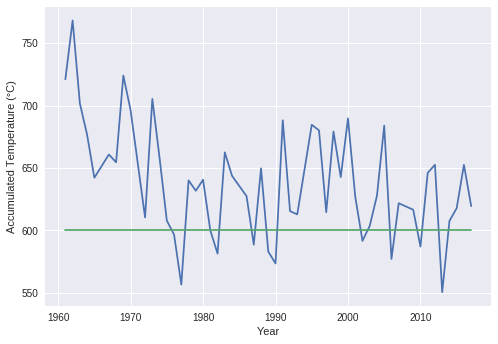

In [17]:
first_problem_predictor.plot()

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [18]:
# Get number of date from Feb 1st to the predicted blooming date (for both T_mean and 600 degree threshold)
BD_T, BD_count_T = first_problem_predictor.predict_with_T_mean(test_year)
BD_600, BD_count_600 = first_problem_predictor.predict_with_600(test_year)
print('BD_j predicted with T_mean:     ', BD_T)
print('BD_j predicted with 600 degree: ', BD_600)
print('BD_j count predicted with T_mean:     ', BD_count_T)
print('BD_j count predicted with 600 degree: ', BD_count_600)

BD_j predicted with T_mean:      [[1966, 3, 23], [1971, 3, 29], [1985, 4, 1], [1994, 3, 31], [2008, 3, 25]]
BD_j predicted with 600 degree:  [[1966, 3, 20], [1971, 3, 27], [1985, 3, 29], [1994, 3, 28], [2008, 3, 23]]
BD_j count predicted with T_mean:      [50, 56, 59, 58, 53]
BD_j count predicted with 600 degree:  [47, 54, 56, 55, 51]


In [19]:
 # Input a year, a month, a day and get index of that day in df_tokyo
def get_idx(year, month, date):
    idx = df_tokyo.loc[(df_tokyo['year'] == year) & 
                     (df_tokyo['month'] == month) & 
                     (df_tokyo['date'] == date)][0:1]['index']
    return int(idx)  

# Get the number of date from Feb 1st to the actual blooming date of years in testing years
BD_count_actual = list()
for index, row in test_data.iterrows():
    if not row['is blooming date']:
        continue
    bloom_year, bloom_month, bloom_date = row['year'], row['month'], row['date']
    idx_start = get_idx(bloom_year, 2, 1)
    idx_end   = get_idx(bloom_year, bloom_month, bloom_date)
    BD_count_actual.append(idx_end - idx_start)
    
print('Actual BD_j count: ', BD_count_actual)

Actual BD_j count:  [47, 57, 61, 58, 50]


In [20]:
print('Compute R2 score using sklearn:')
print('R2 Score for the threshold of 600:    ',sklearn_r2_score(BD_count_actual, BD_count_600))
print('R2 Score for the threshold of T_mean: ',sklearn_r2_score(BD_count_actual, BD_count_T))

Compute R2 score using sklearn:
R2 Score for the threshold of 600:     0.6793002915451896
R2 Score for the threshold of T_mean:  0.8323615160349854


In [0]:
def r2_score(y_true, y_pred):
    y_true_mean = np.mean(y_true)
    SS_total = sum([(y-y_true_mean)**2 for y in y_true])
    SS_res = sum([(yi-fi)**2 for yi, fi in zip(y_true, y_pred)])
    return 1 - SS_res/SS_total

In [22]:
print('Compute R2 score using self-implemented function:')
print('R2 Score for the threshold of 600:    ',r2_score(BD_count_actual, BD_count_600))
print('R2 Score for the threshold of T_mean: ',r2_score(BD_count_actual, BD_count_T))

Compute R2 score using self-implemented function:
R2 Score for the threshold of 600:     0.6793002915451896
R2 Score for the threshold of T_mean:  0.8323615160349854


***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


In [0]:
# Just define some constants
PHI = 35 + 40/60
PHI2 = np.power(PHI,2)
L = 4
lnL = np.log(L)
T_s = 17
R = 8.314

In [0]:
class predictor_linear_reg_model():
  def __init__(self, df_tokyo):
    self.df_tokyo = df_tokyo
    self.training_years = None
    self.D_j = dict()
    self.E_a = range(5, 41)
    self.E_a_MSE = dict()
    self.df_DTS_j = None
    self.DTS_mean = None
    self.best_Ea = None
    
#    According to Hayashi
  def get_Dj(self, year):
      avg_temp_3_month = self.df_tokyo[(self.df_tokyo['year']==year) &
                         (self.df_tokyo['month']<=3)]['Average temperature']
      T_F = np.mean(avg_temp_3_month)
      Dj = 136.75 - 7.689*PHI + 0.133*PHI2 - 1.307*lnL + 0.144*T_F + 0.285*np.power(T_F,2)
      return int(Dj)
    
  def get_T_ij(self, i, j):
      df = clone(self.df_tokyo[self.df_tokyo['year']==j])
      df.reset_index(drop=True, inplace = True)
      return df.iloc[i-1].loc['Average temperature']

  def get_t_s(self, E_a, i, j):
      T_ij = self.get_T_ij(i, j)
      numer = E_a*(T_ij - T_s)
      denom = R*np.abs(T_ij)*T_s
      return np.exp(numer/denom)

  def get_DTS_j(self, E_a, year):
      df = clone(self.df_tokyo[self.df_tokyo['year']==year])
      df.reset_index(drop=True, inplace = True)

      D_j = self.get_Dj(year)
      self.D_j[year] = D_j
      
      BD_j = 0
      for index, row in df.iterrows():
          if row['is blooming date']:
              BD_j = index + 1
              break
      DTS_j = 0
      for i in range(D_j, BD_j):         
          DTS_j += self.get_t_s(E_a, i, year)
      return DTS_j 
  
  def fit(self, training_years):
    self.training_years = training_years
    self.df_DTS_j = pd.DataFrame(columns=['E_a']+ self.training_years)

    for e_a in self.E_a:
      DTS_j = list()
      for year in self.training_years:
          DTS_j.append(self.get_DTS_j(e_a, year))
      self.df_DTS_j.loc[len(self.df_DTS_j)] = [e_a] + DTS_j
    
    self.DTS_mean = list(df_DTS_j.iloc[:,1:].mean(axis='rows'))
    self.optimize_Ea()
    
  def optimize_Ea(self):
    for e_a in self.E_a:
      self.E_a_MSE[e_a] = self.compute_MSE(e_a)
    min = 0
    for key, value in self.E_a_MSE.item():
      if min == 0:
        self.best_Ea = key
        min = value
      else:
        if value < min:
          min = value
          self.best_Ea = key
    
  
  def compute_MSE(self, E_a):
    SE_list = list()
    DTS_Ea = df_DTS_j[df_DTS_j['E_a'] == 5].iloc[0:1,]
    DTS_Ea = DTS_Ea.values[1:]
    for year, DTS in zip(self.training_years, DTS_Ea):
      BD = self.D_j[year] + DTS
      SE = self.compute_square_error(BD ,year)
      SE_list.append(SE)
    return np.mean(SE_list)
    
  def compute_square_error(self, BD_j, year):
    df = clone(self.df_tokyo[self.df_tokyo['year']==year])
    df.reset_index(drop=True, inplace = True)
    actual_BD = 0;
    for index, row in df.iterrows():
      if row['is blooming date']:
        actual_BD = index +1
        break;
    square_error = (actual_BD - BD_j)**2
    return square_error
  
  def predict(self, year):
    if self.best_Ea is None:
      print('You must fit the training data first!')
      return
    DTS_j = self.get_DTS_j(self.best_Ea, year)
    BD_j = self.D_j[year] + DTS_j
    return BD_j
        
    
#     Just some getter
    
  def get_DTS_mean(self):
    return self.DTS_mean
  
  def get_df_DTS_j(self):
    return self.df_DTS_j  
    

### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

In [0]:
second_problem_predictor = predictor_linear_reg_model(df_tokyo)

In [0]:
D_j_dict = dict()
D_j_list = list()

for year in range(1961, 2018):
    Dj = second_problem_predictor.get_Dj(year)
    D_j_dict[year] = Dj
    D_j_list.append(Dj)

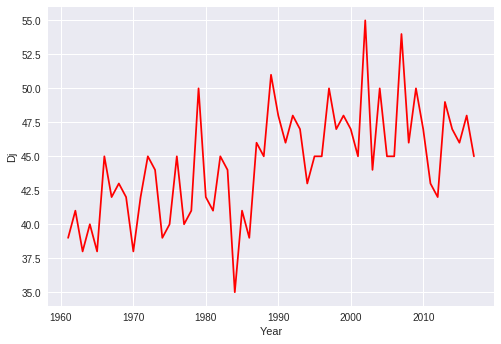

In [26]:
plt.plot(range(1961, 2018), D_j_list, "r-")
plt.xlabel('Year')
plt.ylabel('Dj')
plt.show()

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


In [0]:
second_problem_predictor = predictor_linear_reg_model(df_tokyo)
second_problem_predictor.fit(train_year)

In [106]:
second_problem_predictor.get_df_DTS_j()[0:10]

,E_a,1961,1962,1963,1964,1965,1967,1968,1969,1970,...,2007,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,5.0,48.283924,47.252821,49.082339,48.639358,50.271585,41.749414,42.578531,48.910228,53.981404,...,24.069799,28.729006,32.521304,41.626400,46.219428,24.738842,35.301052,34.472568,31.622190,33.557487
1,6.0,47.598484,46.728776,48.357396,47.843452,49.566268,41.112488,41.966284,48.125359,53.070643,...,23.889568,28.485160,32.239657,41.175181,45.693223,24.498942,34.974057,34.178163,31.356523,33.277461
2,7.0,46.930330,46.212815,47.650187,47.070309,48.873716,40.528383,41.374725,47.388141,52.187318,...,23.711210,28.244613,31.962477,40.731345,45.176388,24.262957,34.651181,33.887311,31.094043,33.000188
3,8.0,46.278717,45.704780,46.960026,46.318921,48.193649,39.984471,40.802655,46.691081,51.330111,...,23.534699,28.007303,31.689670,40.294711,44.668684,24.030805,34.332365,33.599956,30.834705,32.725640
4,9.0,45.642945,45.204520,46.286264,45.588337,47.525794,39.472267,40.248973,46.028291,50.497790,...,23.360010,27.773171,31.421145,39.865105,44.169878,23.802408,34.017550,33.316041,30.578462,32.453785
5,10.0,45.022356,44.711886,45.628286,44.877662,46.869882,38.985895,39.712660,45.395115,49.689203,...,23.187118,27.542156,31.156812,39.442358,43.679745,23.577690,33.706677,33.035512,30.325272,32.184595
6,11.0,44.416329,44.226732,44.985511,44.186047,46.225655,38.521153,39.192778,44.787849,48.903273,...,23.015998,27.314201,30.896584,39.026307,43.198067,23.356576,33.399689,32.758315,30.075089,31.918041
7,12.0,43.824281,43.748915,44.357386,43.512691,45.592858,38.074948,38.688458,44.203519,48.138991,...,22.846625,27.089250,30.640376,38.616796,42.724633,23.138994,33.096529,32.484396,29.827871,31.654093
8,13.0,43.245661,43.278296,43.743388,42.856837,44.971245,37.644936,38.198896,43.639723,47.395410,...,22.678977,26.867248,30.388104,38.213673,42.259239,22.924871,32.797143,32.213704,29.583575,31.392725
9,14.0,42.679949,42.814739,43.143020,42.217769,44.360573,37.229295,37.723348,43.094498,46.671642,...,22.513029,26.648140,30.139688,37.816789,41.801687,22.714140,32.501475,31.946189,29.342161,31.133907


In [108]:
print('DTS mean: ', second_problem_predictor.get_DTS_mean())

DTS mean:  [38.83964258368033, 39.46225786331868, 39.07949202696954, 38.02214774241493, 40.065577280835285, 34.558347880575084, 34.66994745286771, 39.632648518888466, 41.96964571701711, 33.715272038773655, 37.293560987496974, 38.83871619475124, 35.430880437895134, 30.887750347441404, 29.7507918067523, 36.769452569287274, 26.828096413268355, 37.737100345616966, 33.55767486147112, 30.505243763888252, 36.813621000745265, 41.69552238196641, 39.157783202271766, 27.826829616348036, 36.49978226105449, 23.445785763508663, 27.659360356739118, 35.407518103309805, 29.368748502551277, 29.537657381863394, 36.95828831420806, 35.61631084181659, 25.34707006570919, 32.550499779999186, 29.63352117915836, 34.12316941028584, 30.405439704413354, 18.130633775462414, 33.27256633550142, 24.39063649996117, 36.21585106479861, 29.568930494988347, 21.249141467126666, 25.028090865467732, 28.345836415002253, 34.951958408234894, 38.54434360839413, 21.203140476379467, 30.306520874766722, 29.942378720052247, 27.537159

In [0]:
df_DTS_j = second_problem_predictor.get_df_DTS_j()
x, y, z = [], [], []
for e_a in E_a:
    for year in train_year:
        x.append(e_a)
        y.append(year)
        row = df_DTS_j[df_DTS_j['E_a'] == e_a][0:1]
        z.append(float(row[year]))

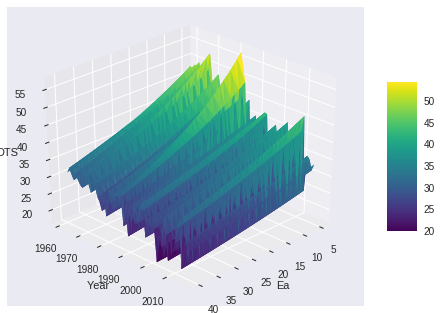

In [110]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.05)
surf=ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.2)

fig.colorbar( surf, shrink=0.5, aspect=5)
ax.view_init(30, 45)

ax.set_xlabel('Ea')
ax.set_ylabel('Year')
ax.set_zlabel('DTS')

plt.show()

### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

In [149]:
second_problem_predictor = predictor_linear_reg_model(df_tokyo)
second_problem_predictor.fit(train_year)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: ignored

In [0]:

# DTS_Ea = list(DTS_Ea)

array([[ 5.        , 48.28392429, 47.25282111, 49.08233894, 48.63935751,
        50.27158537, 41.74941405, 42.57853059, 48.91022805, 53.98140403,
        40.30465196, 43.79038705, 48.87705525, 44.56268795, 35.45609892,
        37.32517336, 45.44115729, 30.70364577, 46.00328657, 40.85582536,
        35.33661596, 43.62501496, 57.54298958, 49.54539129, 33.81001647,
        44.86142777, 26.85281349, 30.20437433, 41.05938721, 34.28649332,
        34.38623857, 42.96423479, 42.76212142, 28.7181389 , 37.3911043 ,
        33.65480375, 40.66596412, 35.29567519, 19.55686115, 39.77062635,
        27.10992551, 42.67392862, 33.65017622, 24.06979942, 28.72900581,
        32.521304  , 41.6263995 , 46.21942784, 24.73884191, 35.30105226,
        34.47256835, 31.62218957, 33.55748676]])

### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.